In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install keras_tuner
import keras_tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.0/128.0 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 14.0 MB/s eta 0:00:00
Using TensorFlow backend


In [ ]:
from tensorflow import keras

In [ ]:
#basics
import pandas as pd
import numpy as np
import tensorflow as tf
import keras

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns

#utility & processing
from tensorflow.keras import utils
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

#cnn architecture
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Sequential

#callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

#data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#keras tuner
import keras_tuner
from keras_tuner import RandomSearch


#transfer learning
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet_v2 import ResNet152V2
from keras.applications.xception import Xception

#warnings
import warnings
warnings.filterwarnings('ignore')




In [ ]:
#loading image data
data_ds= tf.keras.utils.image_dataset_from_directory(
    directory='/content/drive/MyDrive/Data Science Project/Rice Leaf/RiceLeaf',
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(256,256),
    seed=123,
    shuffle=True,
)

Found 119 files belonging to 3 classes.


In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  directory='/content/drive/MyDrive/Data Science Project/Rice Leaf/RiceLeaf',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 119 files belonging to 3 classes.
Using 96 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  directory='/content/drive/MyDrive/Data Science Project/Rice Leaf/RiceLeaf',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 119 files belonging to 3 classes.
Using 23 files for validation.


In [ ]:
#class labels
class_names = train_ds.class_names

print("Class Names:", class_names)

Class Names: ['Bacterial leaf blight', 'Brown spot', 'Leaf smut']


In [ ]:
# Counting the number of samples for each class
class_counts = {}
for images, labels in data_ds:
    for label in labels:
        class_name = data_ds.class_names[label]
        if class_name in class_counts:
            class_counts[class_name] += 1
        else:
            class_counts[class_name] = 1


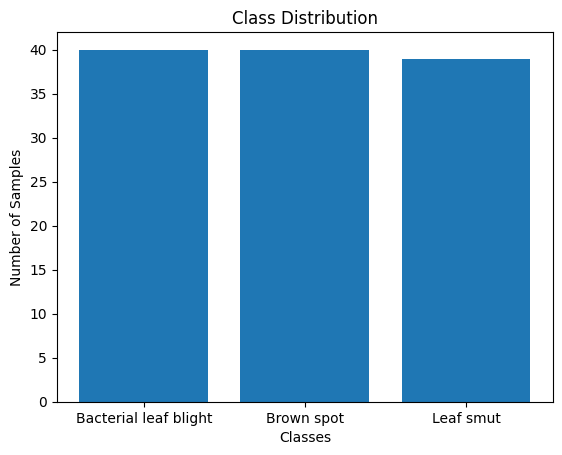

In [ ]:


plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.title('Class Distribution')
plt.show()

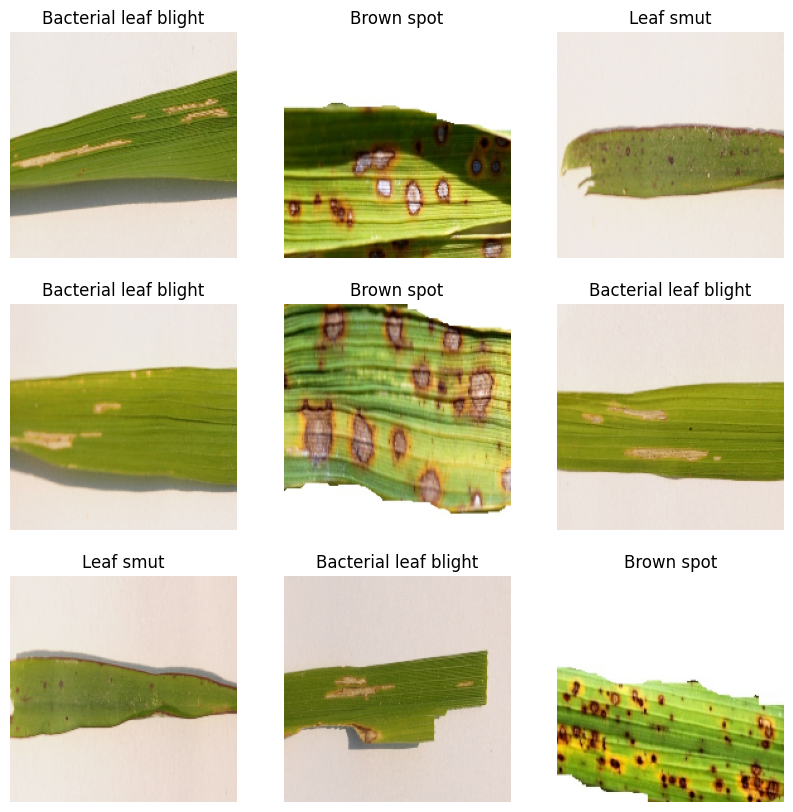

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


# Standardize the data

In [ ]:
from tensorflow.keras import layers
normalization_layer = layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


Create model

In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
# Compile the model
model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])


In [ ]:
# Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

# Train the mode

In [ ]:
epochs = 30
history = model.fit(train_ds,validation_data=val_ds, epochs=epochs, batch_size=32)


Epoch 1/30
3/3 [==============================] - 14s 273ms/step - loss: 2.5484 - accuracy: 0.3958 - val_loss: 1.0659 - val_accuracy: 0.5652
Epoch 2/30
3/3 [==============================] - 1s 115ms/step - loss: 1.4245 - accuracy: 0.2708 - val_loss: 1.0933 - val_accuracy: 0.2609
Epoch 3/30
3/3 [==============================] - 1s 183ms/step - loss: 1.0698 - accuracy: 0.4271 - val_loss: 1.2028 - val_accuracy: 0.2609
Epoch 4/30
3/3 [==============================] - 1s 120ms/step - loss: 1.0313 - accuracy: 0.5938 - val_loss: 1.1386 - val_accuracy: 0.3478
Epoch 5/30
3/3 [==============================] - 1s 184ms/step - loss: 0.9366 - accuracy: 0.6146 - val_loss: 1.2000 - val_accuracy: 0.3043
Epoch 6/30
3/3 [==============================] - 2s 121ms/step - loss: 0.8248 - accuracy: 0.5729 - val_loss: 1.0642 - val_accuracy: 0.3478
Epoch 7/30
3/3 [==============================] - 1s 189ms/step - loss: 0.9348 - accuracy: 0.5000 - val_loss: 1.0055 - val_accuracy: 0.4783
Epoch 8/30
3/3 [===

In [ ]:
test_loss, test_accuracy = model.evaluate(val_ds)

print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)


1/1 [==============================] - 0s 180ms/step - loss: 1.0618 - accuracy: 0.6957
Test loss: 1.0618135929107666
Test accuracy: 0.695652186870575


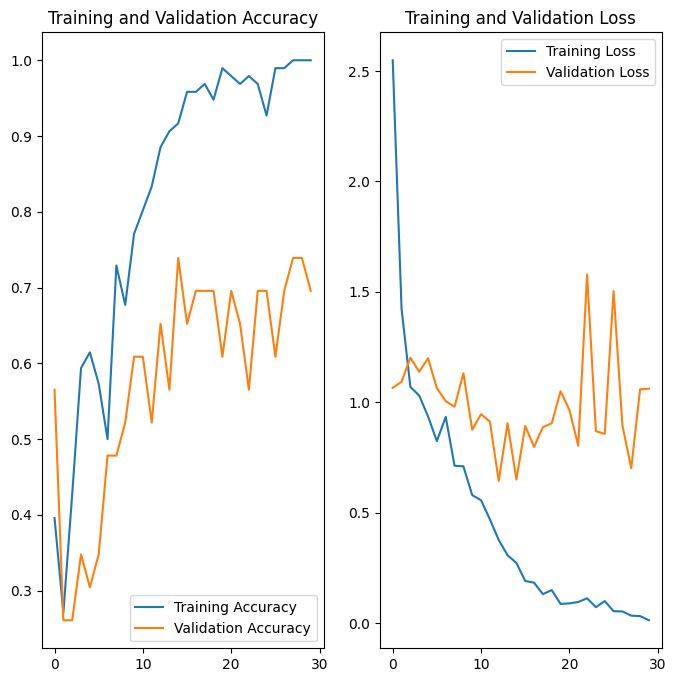

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Data Augmentation

In [ ]:
# Create an ImageDataGenerator object
image_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

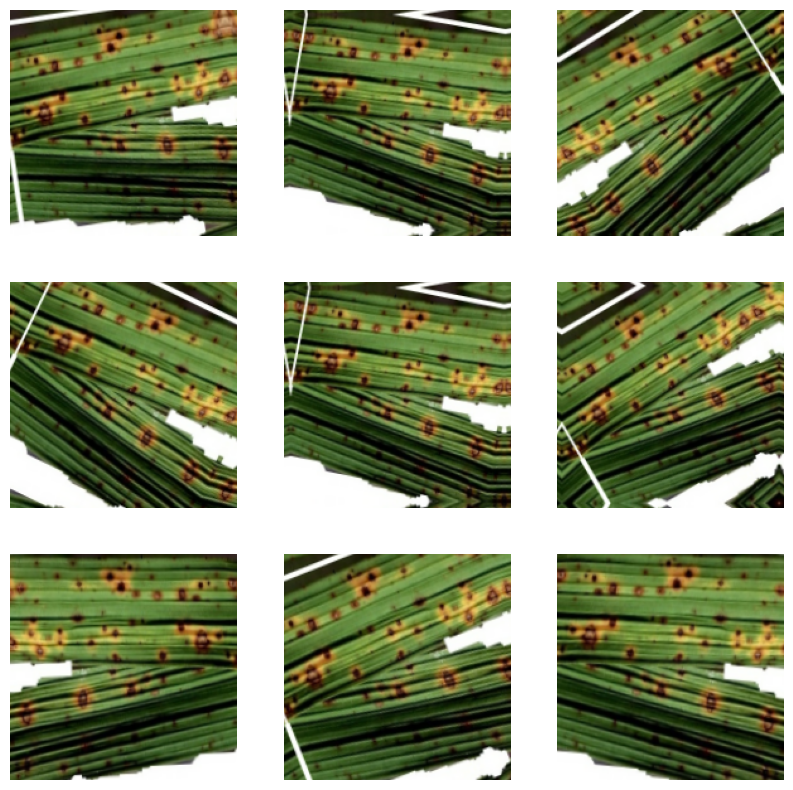

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(6):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

# Create Augmentation model

In [ ]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.1),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

# Compile and train the model

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

In [ ]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
3/3 [==============================] - 3s 265ms/step - loss: 3.3149 - accuracy: 0.3438 - val_loss: 1.0089 - val_accuracy: 0.5652
Epoch 2/30
3/3 [==============================] - 1s 187ms/step - loss: 1.2291 - accuracy: 0.3229 - val_loss: 1.4598 - val_accuracy: 0.2609
Epoch 3/30
3/3 [==============================] - 2s 199ms/step - loss: 1.1080 - accuracy: 0.3542 - val_loss: 1.1302 - val_accuracy: 0.2609
Epoch 4/30
3/3 [==============================] - 2s 356ms/step - loss: 1.0873 - accuracy: 0.3646 - val_loss: 1.1166 - val_accuracy: 0.3478
Epoch 5/30
3/3 [==============================] - 1s 132ms/step - loss: 1.0728 - accuracy: 0.5417 - val_loss: 1.1851 - val_accuracy: 0.2609
Epoch 6/30
3/3 [==============================] - 1s 127ms/step - loss: 1.0455 - accuracy: 0.5104 - val_loss: 1.1936 - val_accuracy: 0.3478
Epoch 7/30
3/3 [==============================] - 1s 132ms/step - loss: 1.0225 - accuracy: 0.4688 - val_loss: 1.0990 - val_accuracy: 0.3478
Epoch 8/30
3/3 [====

In [ ]:
test_loss, test_accuracy = model.evaluate(val_ds)

print('Test Aug loss:', test_loss)
print('Test Aug accuracy:', test_accuracy)

1/1 [==============================] - 0s 186ms/step - loss: 0.8158 - accuracy: 0.7826
Test Aug loss: 0.8157766461372375
Test Aug accuracy: 0.782608687877655


# Visualize training results

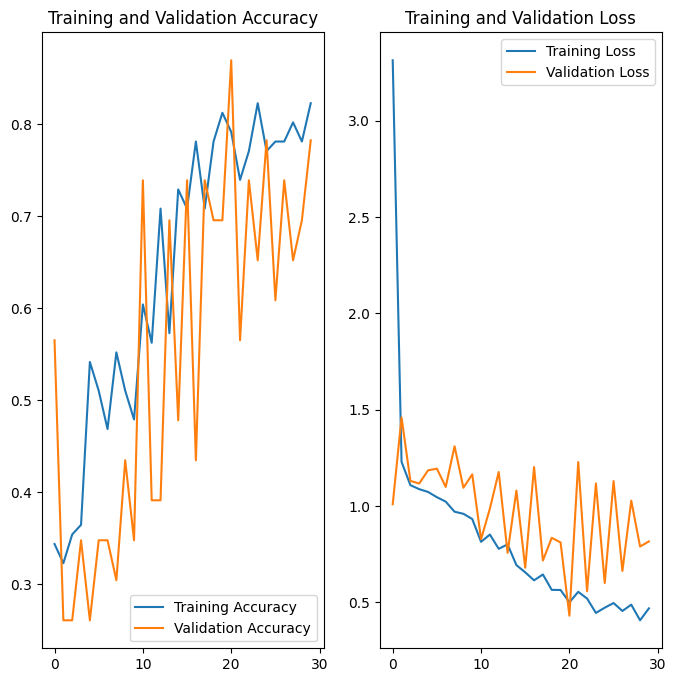

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Model Comparision

1.   Main CNN model provides a accuracy of 69%
2.   Data Augmentation 78%


In conclusion Data augmentation provides the best possible result